# Static portfolio construction
## Basics of portfolio construction

#### by Gustavo Soares

This notebook introduces a few important ideas in portfolio construction. In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures).

## Introduction

Portfolio construction is a large topic, here we focus on the simplest possible case which is the construction of static portfolios give a particular set of signals. We approach the topic from a factor investing persepctive, i.e., we move slightly away from the classic asset allocation framework, such as the [Markowitz mean-variance portfolio problem](https://en.wikipedia.org/wiki/Markowitz_model). For example, even though some of the factors, signals, or asset characteristics can be interpreted as "expected returns", generally we will not require an estimation of an expected return vector.

Moreover, in factor investing, we are typically trying to construct long-short portfolios, so the weights can be negative and they do not necessary add up to any particular number. In particular, in some cases they do not need to be cash neutral, i.e., weights adding up to zero. While single name equity factors are typically constructed in cash-neutral format such as the Fama-French style Q1-Q5 portfolio, factor portfolios in most asset classes are typically implemented with derivatives which do not require any cash allocation. Hence, it does not make sense to restrict yourself to look into portfolios with weights adding up to zero.

Let's import some things we are going to need and get started!

## Get the data

Let's get the same signal and tracker data for currencies we discussed in our [time series strategies](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_strategies_intro.ipynb) notebook.

Our data consists in signals in FX trading:
[carry](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/carry.ipynb), [momentum](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) and [value](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/ppp_value_in_fx.ipynb). For each signal $s$ for $s \in \{carry,momentum,value\}$ we have a value $x_{s,i,t}$ containing the signal $s$ for currency $i$ at time $t$ already appropriately lagged. Remember, that we need to make sure $x_{s,i,t}$ is only using information that was available at the time of trading to predict h-period returns from time $t$ to some time in the future $t+h$. So, the value $x_{s,i,t}$ needs to be calculated using information prior to $t$. Here, we lag the information set by one period and calculate $x_{s,i,t}$ only with information contained in $\mathscr{I}_{t-1}$.

In [2]:
# basic imports
import pandas as pd
import numpy as np
from scipy import stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

# list of currencies we will trade
all_ccys_list = ['AUD', 'BRL', 'CAD', 'CHF', 'CLP',
                 'CNH', 'CZK', 'EUR', 'GBP', 'HUF',
                 'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN',
                 'NOK', 'NZD', 'PLN', 'RUB', 'SEK', 'SGD',
                 'TRY', 'TWD', 'ZAR',]

# get carry data with 1 day lag
carry = pd.read_excel(r'NeoSignals2.xlsx',sheetname='carry',index_col=0)
carry.index = pd.to_datetime(carry.index)
carry = carry[[x for x in carry.columns if x in all_ccys_list]].shift(1).dropna(how='all') # day lag!

# get value data with 1 day lag
value = pd.read_excel(r'NeoSignals2.xlsx',sheetname='value',index_col=0)
value.index = pd.to_datetime(value.index)
value = value[[x for x in value.columns if x in all_ccys_list]].shift(1).dropna(how='all') # day lag!

# get tracker data ... no need for lag here!
tracker_df = pd.read_excel(r'NeoSignals2.xlsx',sheetname='trackers',index_col=0)
tracker_df.index = pd.to_datetime(tracker_df.index)
tracker_df = tracker_df[[x for x in tracker_df.columns if x in all_ccys_list]].dropna(how='all')

# calculate momentum with 1 day lag
mom = tracker_df.pct_change(252).shift(1).dropna(how='all') # day lag!

# get data on the S&P 500 futures excess returns index (JFE3UESU Index)
spx = pd.read_excel(r'NeoSignals2.xlsx',sheetname='JFE3UESU',index_col=0)
spx.index = pd.to_datetime(spx.index)

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


## Static single signal portfolios

We will start with focus on static portfolios, that is, portfolios that are constructed wihtout considering how signals and risks are going to evolve going forward. That is, the focus is on finding a single set of weights, a vector $w = (w_{1},\dots,w_{N})'$ that will be applied in a particular reference date.

In reality, the investor is concerned about a dynamic trading strategy, i.e., she wants to find a squence of $\{(w_{1,t},\dots,w_{N,t})\}_{t}$ which will be applied to positions in different dates $t$. In that context, the investor should try to maximize the present value of future returns of the strategy taking into account how expected excess returns, risks and trading costs will evolve over time.

Let's get started by looking at the carry signal alone:

In [3]:
signal_df = carry.copy()

Let's take the last available date as our reference date:

In [4]:
ref_date = carry.index[-1]
print('This is the reference date: %s' % ref_date.strftime('%d-%b-%y'))

This is the reference date: 19-May-20


### Smoothing signals

Often times, signals can be very noisy. Even in static portfolios, it is common to try to smooth out time variation on signals. For example:

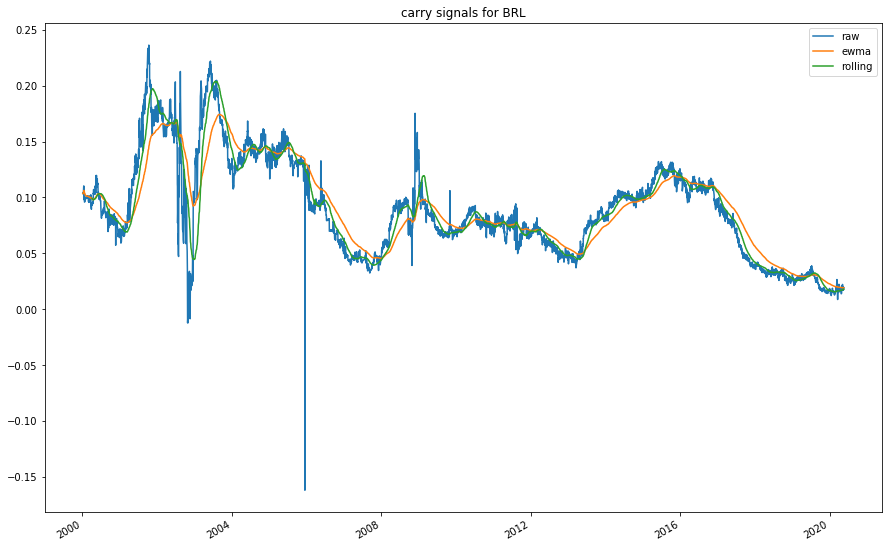

In [5]:
raw_signal_for_BRL = signal_df['BRL'].to_frame('raw')
ewma_signal_for_BRL = (signal_df['BRL'].ewm(halflife=63).mean()).to_frame('ewma')
rolling_signal_for_BRL = (signal_df['BRL'].rolling(63).mean()).to_frame('rolling')
s_for_BRL = pd.concat([raw_signal_for_BRL,ewma_signal_for_BRL,rolling_signal_for_BRL],axis=1,sort=True)
s_for_BRL.plot(title='carry signals for BRL',figsize=(15,10))
plt.show()

As an inllustration, we will get as the signals on our reference date, the EWMA smoothed signals:

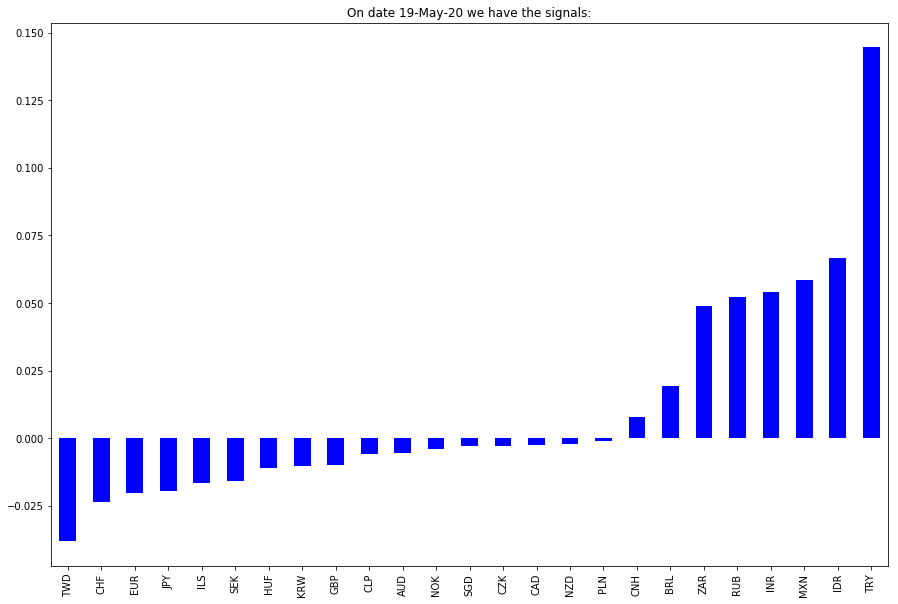

In [6]:
signal_on_date = signal_df.ewm(halflife=63).mean().loc[ref_date]
signal_on_date.sort_values().plot(kind='bar',color='b',figsize=(15,10),
                            title='On date %s we have the signals:' % ref_date.strftime('%d-%b-%y'))
plt.show()

## Fama-French portfolios

The Fama-French factors, or portfolios, are constructed by sorting assets by a particular characteristic or metric (e.g., size and book-to-market) and then going long the top quintile (top 20%) and going short the bottom quitile (bottom 20%).

Fama-French portfolios are typically constructed with single name stocks and there are thousands of them to sort through. If you have thousands of assets to choose from, the top and bottom quintiles will contain a large set of assets and will still be fairly diversified. Because single name stocks Fama-French portfolios are so diversified, Fama-French equal weighting schemes are not too damaging despite the fact that they are not taking into considration that the different stocks have different vols, betas to the market and variable correlations. In fact, the simplicity of Fama-French portfolio constructions is one of its appeals for its use in the academic literature but they are hardly ever used in practice.

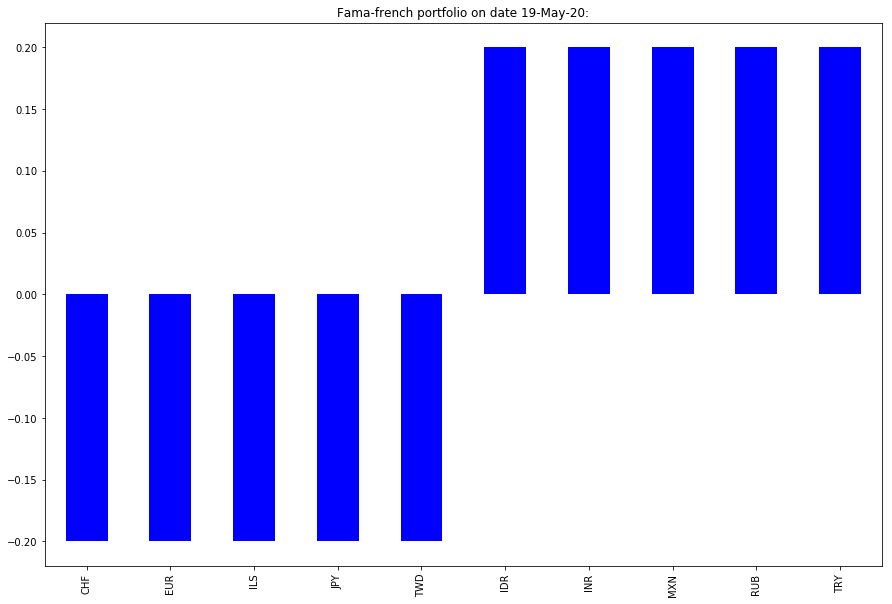

In [7]:
# get the assets in the top and bottom quantile
top_quantile    = signal_on_date[signal_on_date >= signal_on_date.quantile(q=0.8)]
bottom_quantile = signal_on_date[signal_on_date <= signal_on_date.quantile(q=0.2)]

# equally weight the positions
fama_french_long_weights = pd.Series(index=top_quantile.index, data=1/top_quantile.shape[0])
fama_french_short_weights = pd.Series(index=bottom_quantile.index, data=-1/bottom_quantile.shape[0])

fama_french_weights = fama_french_long_weights.append(fama_french_short_weights)
fama_french_weights.sort_values().plot(kind='bar',color='b',figsize=(15,10),
                title='Fama-french portfolio on date %s:' % ref_date.strftime('%d-%b-%y'))
plt.show()

Moreover, cash neutrality is important when constructing single name stock long-short portfolios because the stocks in the top quintile will be purchased with the money collected with the short sale of the stocks in the bottom quitile. However, if you are trading swaps or futures on the underlyings, this restricution does not make any sense. We wil go back to this point later.

## Rank portfolios

In the case of rates, FX and commodities, we only have a few dozen assets to sort through and Fama-French portfolios are typically not ideal from a diversification and risk management perspective. So, even in academia, when constructing factor portfolios, it is preferable to construct rank based portfolios like the ones we have in [here](https://www.aqr.com/Insights/Research/Journal-Article/Carry).

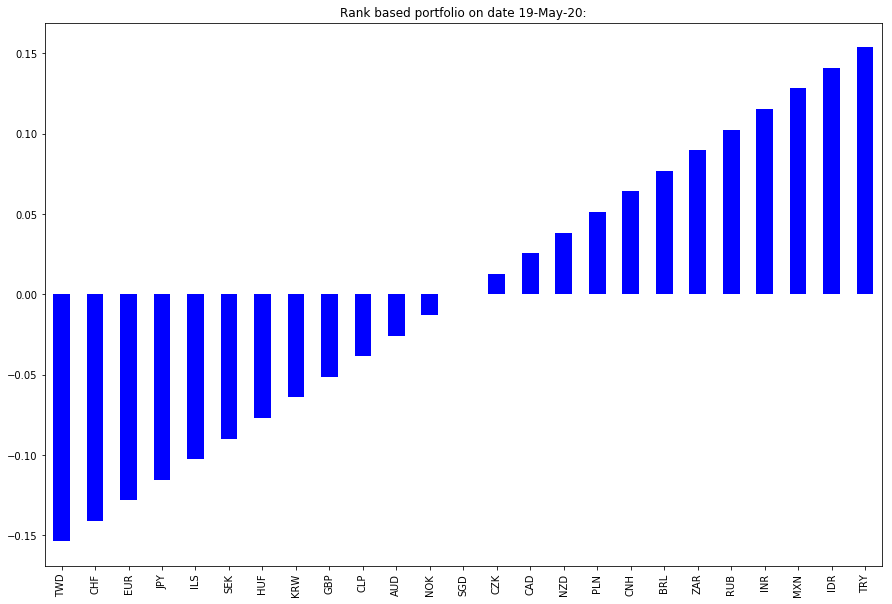

In [8]:
rank_weights = signal_on_date.rank() - signal_on_date.rank().mean()
rank_weights[rank_weights>=0] = rank_weights[rank_weights>=0]/np.abs(rank_weights[rank_weights<0]).sum()
rank_weights[rank_weights<0] = rank_weights[rank_weights<0]/np.abs(rank_weights[rank_weights<0]).sum()
rank_weights.sort_values().plot(kind='bar',color='b',figsize=(15,10),
                title='Rank based portfolio on date %s:' % ref_date.strftime('%d-%b-%y'))
plt.show()

### An alternative normalization of weights

As we discussed, cash neutrality does not make sense when you are trading swaps or futures. Still, rank based portfolios meet that criteria in most academic papers. In the way we constructed the rank based portfolio the absolute value of the weights of the long leg add up to one and so do value of the weights of the short leg.

In [9]:
print('Sum of the weights in the long leg: %s'% rank_weights[rank_weights>=0].sum())
print('Sum of the weights in the short leg: %s'% rank_weights[rank_weights<0].sum())

Sum of the weights in the long leg: 0.9999999999999999
Sum of the weights in the short leg: -1.0


Alternatively, you can just make the absolute value of the weights of all the legs add up to two. When the long and short legs have exactly the same number of assets, the result is the same. But when they do not, this is not necessarily the case:

In [10]:
rank_weights = signal_on_date.rank() - signal_on_date.rank().mean()
rank_weights[rank_weights>=0] = rank_weights[rank_weights>=0]
rank_weights[rank_weights<0] = rank_weights[rank_weights<0]
rank_weights = 2*rank_weights/(np.abs(rank_weights).sum())

## Z-scores weights

Rank based portfolios disregard the strenght of the signal. There are pros and cons for doing this. On one hand, you miss out for example on assets that have much larger/smaller signals than others. On the other hand, you are protected against outlier signals that would make the portfolio concentrate on a few assets with extreme signals.

Z-scores weights are a common way to take into account the strength of the signal and [winsorizing](https://en.wikipedia.org/wiki/Winsorizing) the z-scores is a way to protected against outliers:

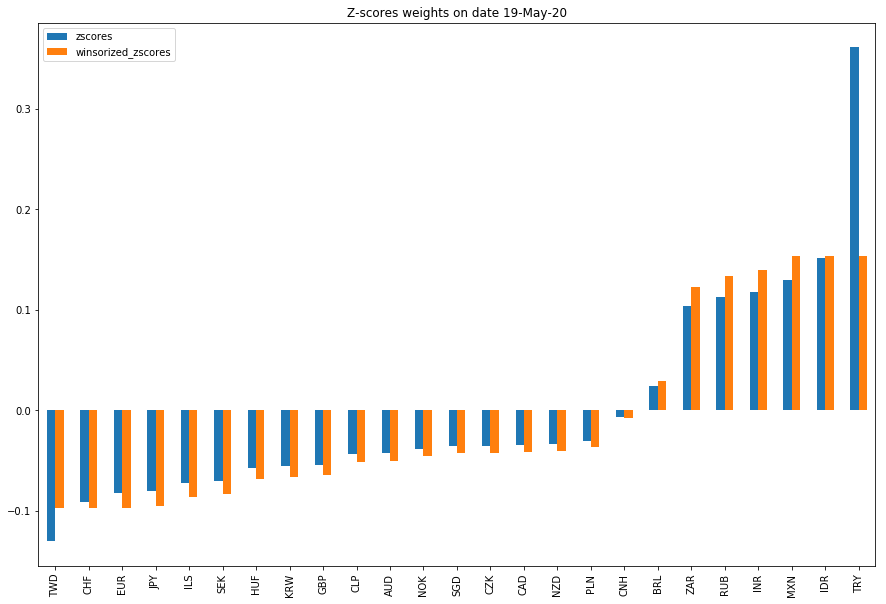

In [11]:
# get the raw z-score of the signal
zscores = pd.Series(index=signal_on_date.index,data=stats.zscore(signal_on_date))

# make sure the absolute value of the weights of each leg adds up to one
zscores[zscores>=0] = zscores[zscores>=0]/np.abs(zscores[zscores>=0]).sum()
zscores[zscores<0] = zscores[zscores<0]/np.abs(zscores[zscores<0]).sum()

# get the winsorized z-score of the signal
winsorized_zscores = stats.mstats.winsorize(stats.zscore(signal_on_date), limits=.1)
winsorized_zscores = pd.Series(index=signal_on_date.index,data=winsorized_zscores)

# make sure the absolute value of the weights of each leg adds up to one
winsorized_zscores[winsorized_zscores>=0] = winsorized_zscores[winsorized_zscores>=0]
winsorized_zscores[winsorized_zscores<0] = winsorized_zscores[winsorized_zscores<0]

# concatenate both set of weights for comparison
both = pd.concat([zscores.to_frame('zscores'),winsorized_zscores.to_frame('winsorized_zscores')]
                 ,axis=1).sort_values(by='zscores')
both = 2*both/(np.abs(both).sum())
both.plot(kind='bar',figsize=(15,10),
                title='Z-scores weights on date %s' % ref_date.strftime('%d-%b-%y'))
plt.show()

## Inverse volatility weights

In the case of rates, FX and commodities, we only have a few dozen assets to sort through. Fama-French, rank based and z-score portfolios do not take into account that some of those assets can be more risky than others. Inverse volatility weights is a way to spread the risk of the portfolio more or less equally across the assets of the portfolio. The main advantage of inverse volatility weights is that portfolio performance will not be dominated by the few assets that have much higher volatility than the others. Also, note that inverse volatility weights are not necessarily cash neutral.

It is common for people to refer to inverse volatility weights as risk-parity portfolios. This is not exactly correct. The risk-parity problem is more similar to the equal risk contribution (ERC) problem we discuss below. The risk parity optimization problem aims to ﬁnd such portfolios for which the contributions of risk from all assets are equally weighted, taking correlations into account. Inverse vol weights is a special case of ERC, if the correlations between all assets are the same.

### Estimating volatility

Estimating volatilities is a very large topic. Here, we will run through three simple methodologies.

First we will use rolling returns:
$$
r_{i,t+h} \equiv \frac{I_{t+h}}{I_{t}}-1
$$

which contains the returns of currency $i$ over the period between $t$ and $t+h$ as measured by the percentage change in the the currency tracker level $I_{t}$ over the period.

In [12]:
h = 21
returns = np.log(tracker_df).diff(h)

Three cases:

* Uncoditional ann. vol estimate using the full sample
* Conditional ann. vol estimate using EWMA (this is very similar to a GARCH model)
* Conditional ann. vol estimate using rolling windows

In [13]:
unc_vol = (returns.std() * np.sqrt(252 / h)).to_frame('unc_vol')
ewma_vol = ((returns.ewm(halflife=63).std().loc[ref_date]) * np.sqrt(252/h)).to_frame('ewma')
roll_vol = ((returns.rolling(63).std().loc[ref_date]) * np.sqrt(252/h)).to_frame('rolling')

Now, let's calculate the weights:

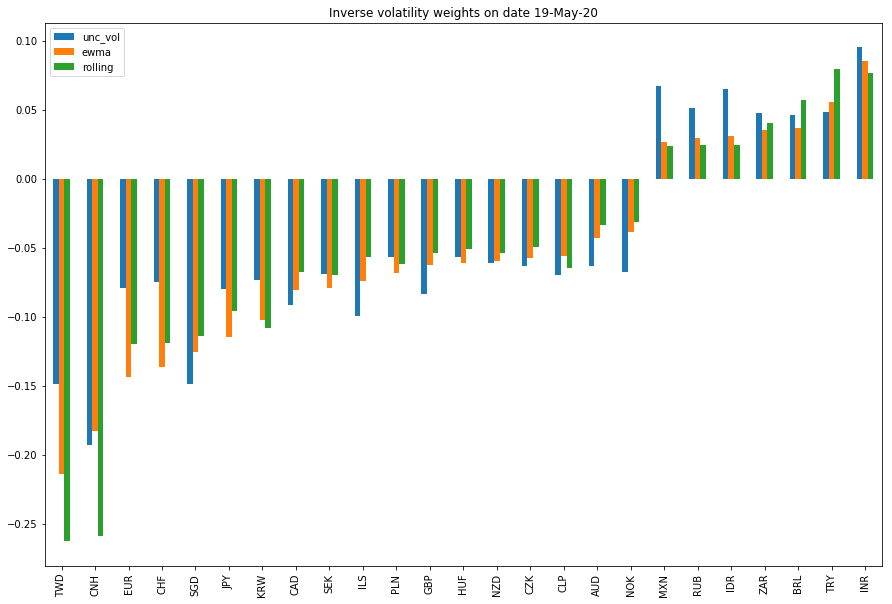

In [14]:
vols = pd.concat([unc_vol,ewma_vol,roll_vol],axis=1)
positions = np.sign(signal_on_date - signal_on_date.mean())
weights = ((1/vols)/((1/vols).sum())).multiply(positions,axis=0)
weights = (2*weights/(np.abs(weights).sum())).sort_values(by='ewma')
weights.plot(kind='bar',figsize=(15,10),
                title='Inverse volatility weights on date %s' % ref_date.strftime('%d-%b-%y'))
plt.show()

## Minimum Variance portfolios

One of the problems with inverse volatility weights is that it disregard correlations across the different assets. There are many portfolio construction methods that take correlations into account. We will start with a simple one, minimum variance portfolios.

The idea of minimum variance portfolios is to find the set of weights that gives us the minimum variance. In a long short portfolio, you can obtain variance equal to zero by setting all the weights to zero. So, minimum variance portfolios are more common in long-only portfolios where the weights are bound to be non-negative. Here, to illustrate the methodolgy we will find the minimum variance portfolio of the long leg and then of the short leg and combine the two in the end.

The main advantage of minimum variance portfolios is that they use the signals in the selection of the long and short leg but they put risk management, not the strength of the signal or expected returns, as the key goal of the weighting scheme, making them robost to asset with extreme signals. On the other hand, minimum variance portfolio will tend to overweight low volatility assets and require considerably more leverage. Again, this should not be a big issue when trading swaps and futures but it is something to be aware.

Before we start, we need to calculate covariance matrices!

### Calculate covariance matrices

Here we have the same three cases:

* Uncoditional ann. COV estimate using the full sample
* Conditional ann. COV estimate using EWMA (this is very similar to a M-GARCH model)
* Conditional ann. COV estimate using rolling windows

In [15]:
unc_cov = (returns.cov() * (252 / h))
ewma_cov = returns.ewm(halflife=63).cov().loc[ref_date] * (252 / h)
roll_cov = returns.rolling(63).cov().loc[ref_date] * (252 / h)

#### Shrinkage towards prior

One of the key arguments against taking covariances and correlation into account is thier instability (and occasional non-positive semi-definitecovariance matrix) making regular optimization problematic. A potential solution is to [shrink the covariance matrix](https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance) using a technique such as [Ledoit-Wolf’s approach](http://www.ledoit.net/honey.pdf).

In practice, shrinkage boils down to a convex transformation, combining the empirical covariance matrix $\Sigma$ with a prior covariance matrix $\Psi$ using a shrinkage parameter $\delta$ which takes values between zero and one:

$$
\Sigma_{shrunk} = \delta \Sigma + (1-\delta)\Psi
$$


To illustrate, let's use shrinkage parameter equal to 0.5 and look at two simple cases.

In [16]:
shrinkage_parameter = 0.5

##### Prior is that correlations are zero
Here, our prior is that the correlations across assets are close to zero. So, if the empirical covariance matrix $\Sigma$ estimates large covariances, we want to shrink them down to zero:

$$
\Sigma_{shrunk} = \delta \Sigma + (1-\delta)diag(\Sigma)
$$

Note that $\Sigma = \sqrt{diag(\Sigma)} \Omega \sqrt{diag(\Sigma)}$ where $\Omega$ is the correlation matrix.

So, we can also write:

$$
\Sigma_{shrunk} = \delta \sqrt{diag(\Sigma)} \Omega \sqrt{diag(\Sigma)} + (1-\delta)diag(\Sigma) =  \sqrt{diag(\Sigma)}[ \delta \Omega + (1-\delta)I]\sqrt{diag(\Sigma)}
$$


In [17]:
cov = ewma_cov.copy()
vols = pd.Series(index=cov.index,data=np.sqrt(np.diag(cov)))
corr = cov.div(vols, axis=0).div(vols, axis=1)
corr = shrinkage_parameter * corr + (1 - shrinkage_parameter) * np.eye(len(vols))
srunk_cov1  = corr.multiply(vols, axis=0).multiply(vols, axis=1).copy()

##### Prior is that correlations are one

Here, our prior is that the correlations across assets are close to one. So, if the empirical correlation matrix $\Omega$ estimates small correlations, we want to shrink them down:

$$
\Sigma_{shrunk} = \sqrt{diag(\Sigma)}[ \delta \Omega + (1-\delta)\iota]\sqrt{diag(\Sigma)}
$$

where $\iota\$ is a correlation matrix full of ones.

In [18]:
cov = ewma_cov.copy()
vols = pd.Series(index=cov.index,data=np.sqrt(np.diag(cov)))
corr = cov.div(vols, axis=0).div(vols, axis=1)
corr = shrinkage_parameter * corr + (1 - shrinkage_parameter) * np.ones(corr.shape)
srunk_cov2  = corr.multiply(vols, axis=0).multiply(vols, axis=1).copy()

###### Let's compare them

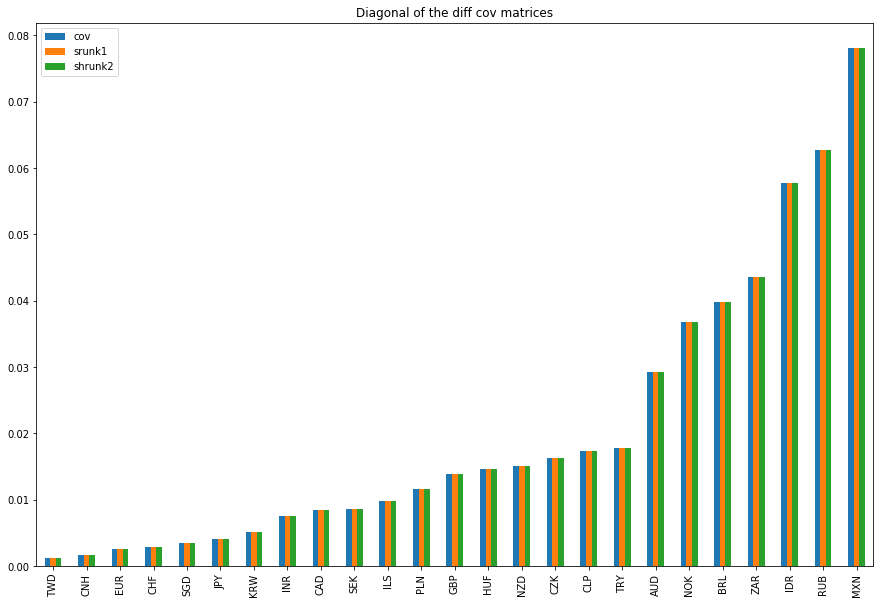

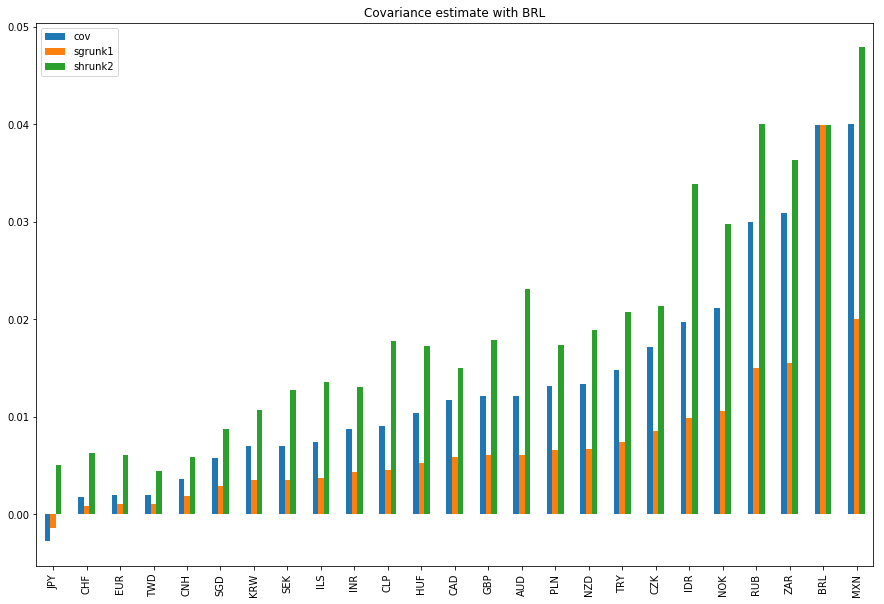

In [19]:
compare_vols = pd.DataFrame(index=['cov','srunk1','shrunk2'],
             columns=cov.index,
             data = np.array([np.diag(cov),np.diag(srunk_cov1),np.diag(srunk_cov2)])).T

compare_vols.sort_values(by='cov').plot(kind='bar',figsize=(15,10),
                                        title='Diagonal of the diff cov matrices')
plt.show()

ccy = 'BRL'

compare_covariance = pd.concat([cov[ccy].to_frame('cov'),
                       srunk_cov1[ccy].to_frame('sgrunk1'),
                       srunk_cov2[ccy].to_frame('shrunk2')],axis=1)

compare_covariance.sort_values(by='cov').plot(kind='bar',figsize=(15,10),
                                        title='Covariance estimate with %s' % ccy)
plt.show()

##### Set the covariance matrix to be used

In [20]:
cov = srunk_cov1.copy()

##### Constraints

Put the equality constraints in a tuple containing a dictionary that specifies the type 'eq' for equality constraints and 'ineq' for inequality constraints and the function in the format $g(x) = 0$ if it's an equality constraint and in the format $g(x) \geq 0$ if it's an inequality constraint.

In [21]:
eq_cons = ({'type': 'eq', 'fun': lambda x: np.abs(x).sum() - 1})

##### Find weights in the long leg with minimum variance

For any vector of weights $w = (w_{1},\dots,w_{N})'$ we have the variance function as the function:

$$
Var(w) \equiv w'\Sigma w
$$

Make sure the vector $w$ and your estimate $\Sigma$ are in the right order!

In [22]:
long_ccys = positions[positions>=0].index
long_w0 = rank_weights[long_ccys].values

long_leg_port_variance = lambda x: x.dot(cov.loc[long_ccys,long_ccys]).dot(x)
long_bounds = np.array([np.zeros(long_w0.shape[0]),np.ones(long_w0.shape[0])]).T

res = opt.minimize(long_leg_port_variance, long_w0, method='SLSQP',
                   bounds=long_bounds, constraints=eq_cons)
long_leg_weights = pd.Series(index=long_ccys,data=res.x)
long_leg_weights

BRL    2.671344e-02
IDR    0.000000e+00
INR    7.292673e-01
MXN    2.818926e-18
RUB    7.806256e-18
TRY    2.440192e-01
ZAR    0.000000e+00
dtype: float64

##### Find weights in the short leg with minimum variance

In [23]:
short_ccys = positions[positions<0].index
short_w0 = rank_weights[short_ccys].values
short_leg_port_variance = lambda x: x.dot(cov.loc[short_ccys,short_ccys]).dot(x)
short_bounds = np.array([-np.ones(short_w0.shape[0]),np.zeros(short_w0.shape[0])]).T
res = opt.minimize(short_leg_port_variance, short_w0, method='SLSQP',
                   bounds=short_bounds, constraints=eq_cons)
short_leg_weights = pd.Series(index=short_ccys,data=res.x)
short_leg_weights

AUD    0.000000e+00
CAD   -1.067491e-17
CHF   -1.920077e-01
CLP   -1.464868e-02
CNH   -6.032202e-18
CZK    0.000000e+00
EUR   -1.773592e-01
GBP   -4.956452e-18
HUF    0.000000e+00
ILS   -9.355350e-02
JPY   -1.651174e-01
KRW   -8.408392e-02
NOK   -2.442298e-17
NZD   -1.334822e-18
PLN   -1.296614e-18
SEK    0.000000e+00
SGD   -1.441996e-18
TWD   -2.732296e-01
dtype: float64

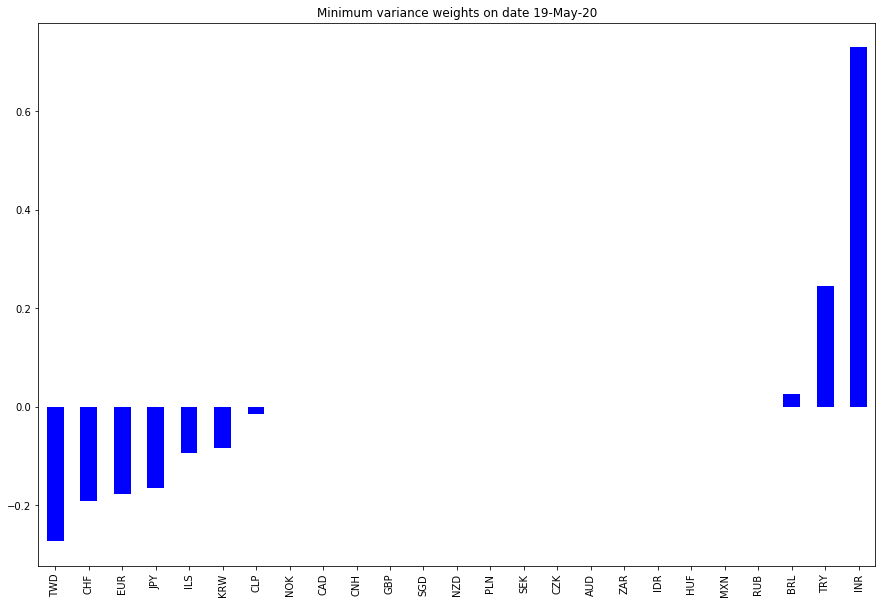

In [24]:
weights = long_leg_weights.append(short_leg_weights)
weights = (2*weights/(np.abs(weights).sum())).sort_values()
weights.plot(kind='bar',figsize=(15,10),color='b',
                title='Minimum variance weights on date %s' % ref_date.strftime('%d-%b-%y'))
plt.show()

## Utility Maximization and the mean variance portfolio

Different people or institutions may have different ways in which they would like to balance risk and return in a portfolio. In academia, it's common to take preferences into account. Typically, the investor is represented by its expected utility function $U_{P}:R\rightarrow R$ which is a function of the probability distribution $P$ because it is defined as $U_{P}(\cdotp)\equiv E_{P}[u(\cdotp)]$ for some strictly increasing function $u:R\rightarrow R$ where $E_{P}[\cdotp]$ is the expectations operator defined by the probability space $\left\{ \Omega,\sigma\left(\Omega\right),P\right\}$. The investor buys the $q\in R^{N}$ portfolio by its market value, $p'q\in R$, and is entitled to its random payoff $q'D:\Omega\rightarrow R$ as a result of this purchase. The investor derives expected utility $U_{P}(q'(D-p))$ as a result of this purchase and will choose how many units of account of each security q accordingly. The investor's static portfolio problem is defined to be:

$$
\underset{q\in B_{P}}{max}U_{P}(q'(D-p))
$$

where $B_{P}\subset R^{N}$ is the set of feasible portfolios. The set $B_{P}$ may include all sorts of budgetary constraitns such as borrowing constraints, risk budget constraints, leverage constraints, etc. which may or may not depend on the the probability distribution P.

This is a pretty general set up that includes some more familiar particular cases. For example, in the particular case where all asset prices $p\in R^{N}$ are non-zero, we can also define a random variable $r:\Omega\rightarrow R^{N}$ where $r=(D-p)/p$ where the symbol / represents element-wise division of vectors. The random variable $r:\Omega\rightarrow R^{N}$ represents the returns of each asset $i\in\{1,\cdots,N\}$ in different states of the economy $\omega\in\Omega$. If we also define a vector of weights $w\equiv p\cdotp q$, where the symbol $\cdotp$ represents element-wise multiplication of vectors, the static portfolio problem can be written as a function of weights and asset returns:

$$
\underset{w\in C_{P}}{max}U_{P}(w'r)
$$

where $C_{p}=\{w\in R^{N}|w=p\cdotp q\,\forall\,q\in B_{P}\}$.

The role of the utility function $u:R\rightarrow R$ is to balance the risk and return preferences, potentially considering not only volatility as a measure of risk but also higher moments of the distribution of returns. Let's use a Taylor expansion and expand $U_{P}(w'r)$ around zero:

$$
U_{P}(w'r) = U_{P}(0) + U'_{P}(0)E_{P}[w'r] + \frac{1}{2}U''_{P}(0)E_{P}[(w'r)^{2}] + \frac{1}{3!}U^{(3)}_{P}(0)E_{P}[(w'r)^{3}] + \frac{1}{4!}U^{(4)}_{P}(0)E_{P}[(w'r)^{4}] + \dots
$$

Since $U_{P}(0)$ is always a constant, the utility maximization problem can be seen as:

$$
\underset{w\in C_{P}}{max} \Big(U'_{P}(0)E_{P}[w'r] + \frac{1}{2}U''_{P}(0)E_{P}[(w'r)^{2}] + \frac{1}{3!}U^{(3)}_{P}(0)E_{P}[(w'r)^{3}] + \frac{1}{4!}U^{(4)}_{P}(0)E_{P}[(w'r)^{4}] + \dots \Big)
$$


So, the $k$-th derivative of the utility function, $U^{(k)}_{P}$, more or less "weighs" how much the investor values or penalizes each $k$-th moment of the distribution of returns.

The use of utility functions are somewhat of an academic exercise since we do not really know the shape and form of the utility function. In fact, not even the investors herself may know and there are results in behavioral economics showing that often times real choices by real investors are incompatible with most utility functions used in academic papers. Still, most academic papers or practical applications of utility function involve functions of the a special case of [Constant Relative Risk Aversion (CRRA)](https://en.wikipedia.org/wiki/Isoelastic_utility) utility functions:


$$
u(w'r) \equiv \frac{(1+w'r)^{\gamma}}{1-\gamma}
$$

where the parameters $\gamma$ is a non-negative constant for risk averse agents and sets the degree of relative risk aversion of the investor. This and only this utility function has the feature of constant relative risk aversion. Mathematically this means that $xu''(x)/u'(x)$, a term that appears in the FOC of the maximization problema above, is a constant and equal to $\gamma$.


We have as a particular case the case where $\gamma \rightarrow 1$ and we have $u(w'r) \rightarrow ln(w'r)$ and, in this particular, the maximization problem becomes:

$$
\underset{w\in C_{P}}{max} \Big(w'\mu - \frac{1}{2}w'\Sigma w \Big)
$$

where $\mu$ and $\Sigma$ are expectation and the covariance matrix of the of the returns, respectively. This particular case is often refered to as the Markowitz Mean-Variance portfolio.

The Markowitz’s efficient frontier problem is finding weights $w$ that maximize the function above for a constant target portfolio return of $r^{p}$, that is

$$
\underset{w\in C_{P}}{max} \Big(w'\mu - \frac{1}{2}w'\Sigma w \Big)
$$


where $C_{P}$ is the set $\{w\in R^{N}|w'\mu=r^{p}\}$. Or equivalently, minimize the portfolio variance, $w'\Sigma w$ subject to $w'\mu=r^{p}$.

The capital market line is the set $\{(r^{p},\sigma)\in R^{2}|\sigma=\sqrt{w(c,\mu)'\Sigma w(c,\mu)},r^{p}=(c/\mu'\Sigma\mu)(\Sigma^{-1}\mu)\forall\,c\in R_{+}\}$ where the weights $w(c,\mu)$ are in $\{w\in R^{N}|w=(c/\mu'\Sigma\mu)(\Sigma^{-1}\mu)\forall\,c\in R_{+}\}$.

Let's take a look at an example now.


### Expected returns, the vector $\mu$

Let's assume that we expect return in proporion to the signal, let's use the winsorized zscores as our vector of expected return. In order to make the dimension of $\mu$ more or less in line with the dimension of our estimates for the covariance matrix, let's just multiply those winsorized zscores by the volatility of each currency:

In [38]:
mu = winsorized_zscores*vols

### Efficient frontier, the case where $w\geq 0$ and $\sum_{i=1}^{N}w_{i}=1$

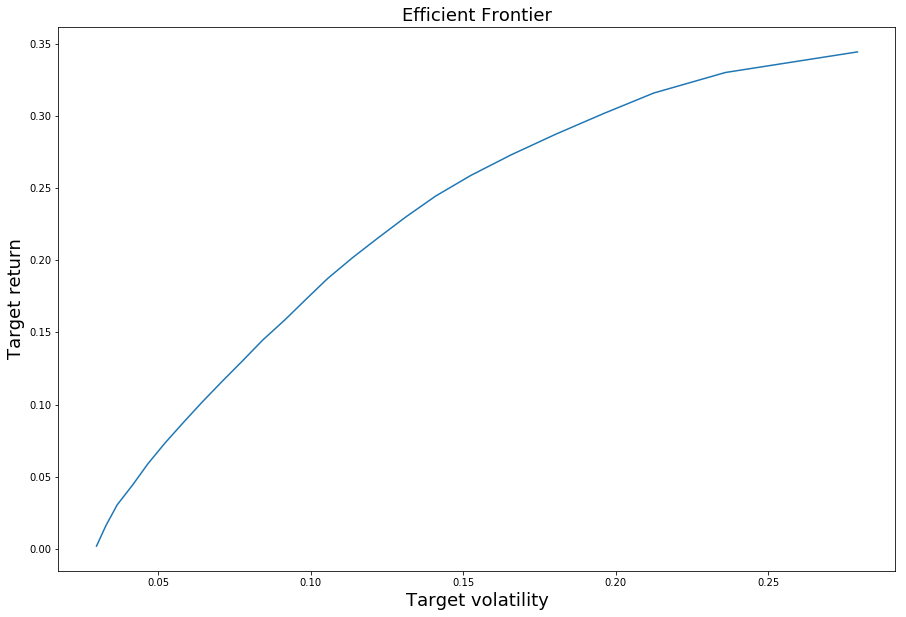

In [25]:
def get_port(rp,mu,cov):
    
    w0 = np.array([1/mu.shape[0]]*mu.shape[0])
    
    mean_variance = lambda x : 0.5 * x.dot(cov).dot(x)
    
    eq_cons = ({'type': 'eq', 'fun': lambda x: x.sum() - 1},
               {'type': 'eq', 'fun': lambda x: x.dot(mu)- rp})

    res = opt.minimize(mean_variance, w0, method='SLSQP',
                bounds=np.array([np.zeros(mu.shape[0]),np.ones(mu.shape[0])]).T,
                       constraints=eq_cons)
    
    w = pd.Series(index=mu.index,data=res.x).to_frame(rp)

    return w, np.sqrt(res.fun * 2)

weights_df = pd.DataFrame()
frontier = pd.Series()

for rp in np.linspace(0.002, mu.max(), 25):
    w, s = get_port(rp,mu,cov)
    weights_df = weights_df.append(w.T)
    frontier[s] = rp
    
frontier.sort_index().plot(figsize=(15,10))
plt.title('Efficient Frontier',fontsize=18)
plt.ylabel('Target return',fontsize=18)
plt.xlabel('Target volatility',fontsize=18)
plt.show()

### Capital market line the case where $w\geq 0$

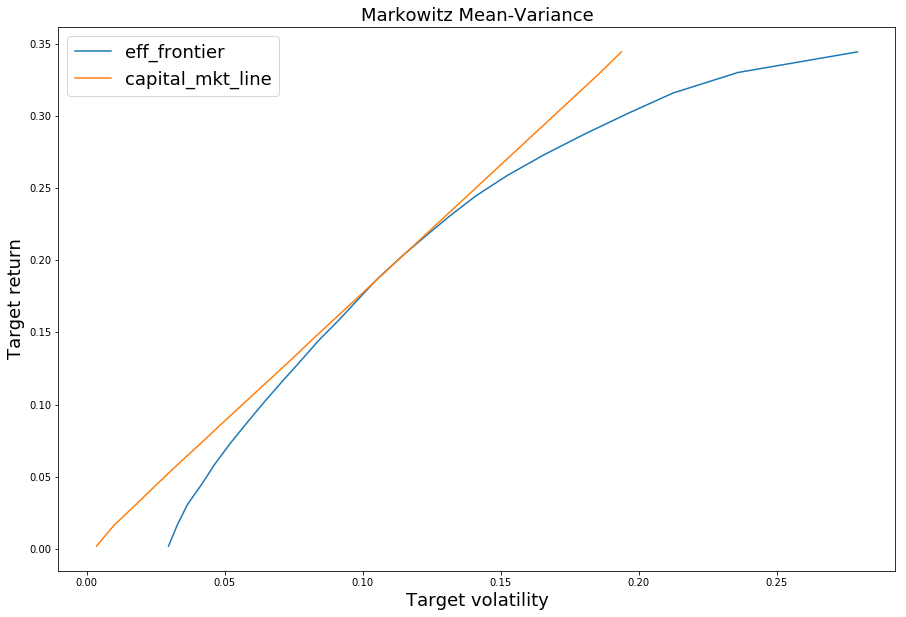

In [26]:
def get_cml(rp,mu,cov):
    w0 = np.array([1/mu.shape[0]]*mu.shape[0])
    
    mean_variance = lambda x : 0.5 * x.dot(cov).dot(x)
    eq_cons = ({'type': 'eq', 'fun': lambda x: x.dot(mu)- rp})

    res = opt.minimize(mean_variance, w0, method='SLSQP',
                bounds=np.array([np.zeros(mu.shape[0]),np.ones(mu.shape[0])]).T,
                       constraints=eq_cons)
    
    w = pd.Series(index=mu.index,data=res.x).to_frame(rp)

    return w, np.sqrt(res.fun * 2)

weights_df = pd.DataFrame()
cml = pd.Series()

for rp in np.linspace(0.002, mu.max(), 25):
    w, s = get_cml(rp,mu,cov)
    weights_df = weights_df.append(w.T)
    cml[s] = rp

frontier.sort_index().plot(figsize=(15,10))
cml.sort_index().plot(figsize=(15,10))
plt.title('Markowitz Mean-Variance',fontsize=18)
plt.ylabel('Target return',fontsize=18)
plt.xlabel('Target volatility',fontsize=18)
plt.legend(['eff_frontier','capital_mkt_line'],fontsize=18)
plt.show()

### Long-short portfolio

The long-short portfolio can achieve more:

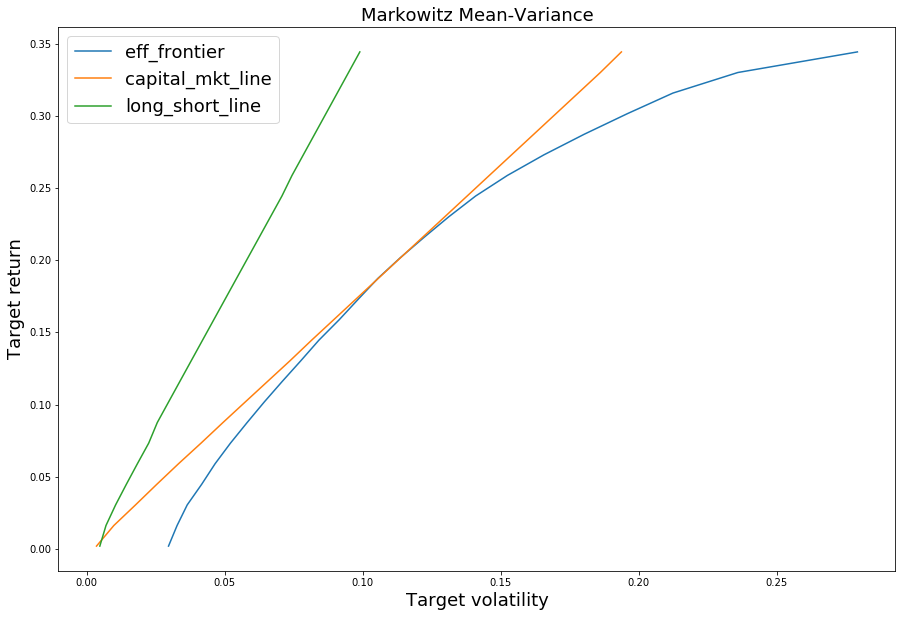

In [27]:
def get_lsp(rp,mu,cov):
    w0 = np.array([1/mu.shape[0]]*mu.shape[0])
    
    mean_variance = lambda x : 0.5 * x.dot(cov).dot(x)
    eq_cons = ({'type': 'eq', 'fun': lambda x: x.dot(mu)- rp})

    res = opt.minimize(mean_variance, w0, method='SLSQP',                       
                bounds=np.array([-np.ones(mu.shape[0]),np.ones(mu.shape[0])]).T,
                       constraints=eq_cons)

    w = pd.Series(index=mu.index,data=res.x).to_frame('rp')
    return w, np.sqrt(res.fun * 2)

weights_df = pd.DataFrame()
lsp = pd.Series()

for rp in np.linspace(0.002, mu.max(), 25):
    w, s = get_lsp(rp,mu,cov)
    weights_df = weights_df.append(w.T)
    lsp[s] = rp

frontier.sort_index().plot(figsize=(15,10))
cml.sort_index().plot(figsize=(15,10))
lsp.sort_index().plot(figsize=(15,10))
plt.title('Markowitz Mean-Variance',fontsize=18)
plt.ylabel('Target return',fontsize=18)
plt.xlabel('Target volatility',fontsize=18)
plt.legend(['eff_frontier','capital_mkt_line','long_short_line'],fontsize=18)
plt.show()

## Equal Risk Contribution Portfolio

Equal risk contribution is a portfolio construction method that take correlations into account that is a little bit more appropriate for long-short portfolios than the minimum variance portfolios.

The idea of equal risk contribution portfolios is that every position, long or short, is bringing the same amount of marginal risk to the portfolio. Like minimum variance portfolios, equal risk contribution uses the signals in the selection of the long and short leg but risk management, not the strength of the signal or expected returns, is the key goal of the weighting scheme, making them robust to assets with extreme signals. On the other hand, minimum variance portfolio will tend to overweight low volatility assets or assests that have been tradionally diversifying.

### Volatility function

For any vector of weights $w = (w_{1},\dots,w_{N})'$ we have the volatility function as the function:

$$
\sigma(w) \equiv \sqrt{w'\Sigma w}
$$

Make sure the vector $w$ and your estimate $\Sigma$ are in the right order!

In [61]:
right_order = rank_weights.index
print('Make sure currencies are in order:\n')
print(list(right_order))
port_vol = lambda x : np.sqrt(x.dot(cov.loc[right_order,right_order]).dot(x))
print('\nThe vol of the rank based portfolio is %s' % port_vol(rank_weights))

Make sure currencies are in order:

['AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNH', 'CZK', 'EUR', 'GBP', 'HUF', 'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN', 'RUB', 'SEK', 'SGD', 'TRY', 'TWD', 'ZAR']

The vol of the rank based portfolio is 0.09624008778488453


### Volatility budget constraint

We will impose the constraint that the optimal weights 

$$
\sigma(\hat{w}) \equiv \sqrt{\hat{w}'\Sigma \hat{w}} \leq 0.05
$$


In [66]:
vol_target = 0.05
print('The vol budget is <= %s' % vol_target)
cons = ({'type': 'ineq', 'fun': lambda x:  vol_target - port_vol(x)})

The vol budget is <= 0.05


### Risk contribution

It turns out that the function $\sigma(w)$ has a special property, called [homogeneity of degree one](https://en.wikipedia.org/wiki/Homogeneous_function). This property, by Euler's homogeneous function theorem, allows us to write the volatility function as:

$$
\sigma(w) = \sum_{i=1}^{N}w_{i}{\frac{\partial \sigma(w)}{\partial w_{i}}}
$$

Since the values 

$$
w_{i}\frac{\partial \sigma(w)}{\partial w_{i}}
$$

add up to the overall risk of the portfolio, we can think of this term above as the marginal risk contribution of asset $i$ to the overall portfolio risk. Moreover, in matrix notation we have:

$$
w\frac{\partial \sigma(w)}{\partial w} = w\frac{\Sigma w}{\sigma(w)} 
$$

If we want to express the marginal risk contribution of the vector of weights $w$ as a percentage of the overall portfolio volatility we can the define:

$$
RC(w) \equiv \frac{w}{\sigma(w)}\frac{\partial \sigma(w)}{\partial w} = w\frac{\Sigma w}{\sigma(w)^2} 
$$

In [30]:
risk_contribution = lambda x: x * (x @ cov / (port_vol(x) ** 2))
print('The actual risk contribution of each position on the rank based portfolio is:')
risk_contribution(rank_weights)

The actual risk contribution of each position on the rank based portfolio is:


AUD   -0.015510
BRL    0.084867
CAD    0.012012
CHF    0.005918
CLP   -0.011993
CNH    0.006682
CZK    0.007585
EUR    0.003211
GBP   -0.019901
HUF   -0.019298
IDR    0.235515
ILS   -0.036656
INR    0.060047
JPY    0.012725
KRW   -0.011665
MXN    0.281116
NOK   -0.011301
NZD    0.020905
PLN    0.022395
RUB    0.172996
SEK   -0.023045
SGD    0.000000
TRY    0.103019
TWD   -0.001751
ZAR    0.122128
Name: 2020-05-19 00:00:00, dtype: float64

###  Target risk contributions


The idea of equal risk contribution strategy is to find a risk-balanced portfolio such that the
risk contribution is the same for all assets of the portfolio:

$$
w_{i}\frac{\partial \sigma(w)}{\partial w_{i}} = w_{j}\frac{\partial \sigma(w)}{\partial w_{j}} = c
$$

for every asset $i$ and asset $j$ in the portfolio. This would imply that

$$
\sigma(w) = \sum_{i=1}^{N}w_{i}{\frac{\partial \sigma(w)}{\partial w_{i}}} = \sum_{i=1}^{N}c = Nc
$$

Note, that $c = \sigma(w)/N$. So, our target marginal risk exposure in percentage terms is given by:

$$
\frac{w_{i}}{\sigma(w)}\frac{\partial \sigma(w)}{\partial w_{i}} = \frac{1}{N}
$$

and therefore

$$
RC(w) \equiv \frac{w}{\sigma(w)}\frac{\partial \sigma(w)}{\partial w} = N^{-1} \iota
$$

where $\iota$ is an $N\times1$ vector of ones.

In [31]:
n = positions.shape[0]
target_risk_contribution = np.ones(n) / n
target_risk_contribution = pd.Series(index=right_order,data=target_risk_contribution)
target_risk_contribution

AUD    0.04
BRL    0.04
CAD    0.04
CHF    0.04
CLP    0.04
CNH    0.04
CZK    0.04
EUR    0.04
GBP    0.04
HUF    0.04
IDR    0.04
ILS    0.04
INR    0.04
JPY    0.04
KRW    0.04
MXN    0.04
NOK    0.04
NZD    0.04
PLN    0.04
RUB    0.04
SEK    0.04
SGD    0.04
TRY    0.04
TWD    0.04
ZAR    0.04
dtype: float64

###  Distance between actual risk contribution and target risk contribution

Instead of trying to find a solution to the equation:
$$
RC(w) = N^{-1} \iota
$$
we will find the vector $w$ that minimizes:

$$ dist(w) \equiv \lVert RC(w) - N^{-1}\iota \rVert $$

which measures the (euclidian) distance between the vector $RC(w)$ and the vector $N^{-1}$ in the $N\times1$ dimensional space.

In [32]:
dist_to_target = lambda x: np.linalg.norm(risk_contribution(x) - target_risk_contribution)
print('The distance between the actual and target risk contribution vectors is: %s' \
                          % dist_to_target(rank_weights))
print('The idea is to make this distance zero or just as small as possible!')

The distance between the actual and target risk contribution vectors is: 0.40674803780001084
The idea is to make this distance zero or just as small as possible!


### Set bounds for weights

Let's make sure that the weights of assets with above average signals are non-negative and the weights of below average signals are negative. We also do not let any particular asset have exposure beyond 100% of the entire portfolio notional. But you can try using `Numpy.inf` if you do not want to impose that restrition:

In [62]:
positions = np.sign(signal_on_date - signal_on_date.mean())[right_order]
optimization_bounds = pd.DataFrame(index=positions.index,columns=['L','U'])
optimization_bounds['L'] = positions.apply(lambda x : min(x,0)) # try using min(x*np.inf,0)!
optimization_bounds['U'] = positions.apply(lambda x : max(x,0)) # try using max(x*np.inf,0)!
optimization_bounds

,L,U
AUD,-1.0,0.0
BRL,0.0,1.0
CAD,-1.0,0.0
CHF,-1.0,0.0
CLP,-1.0,0.0
CNH,-1.0,0.0
CZK,-1.0,0.0
EUR,-1.0,0.0
GBP,-1.0,0.0
HUF,-1.0,0.0


### Optimize

Now we are ready to optimize:

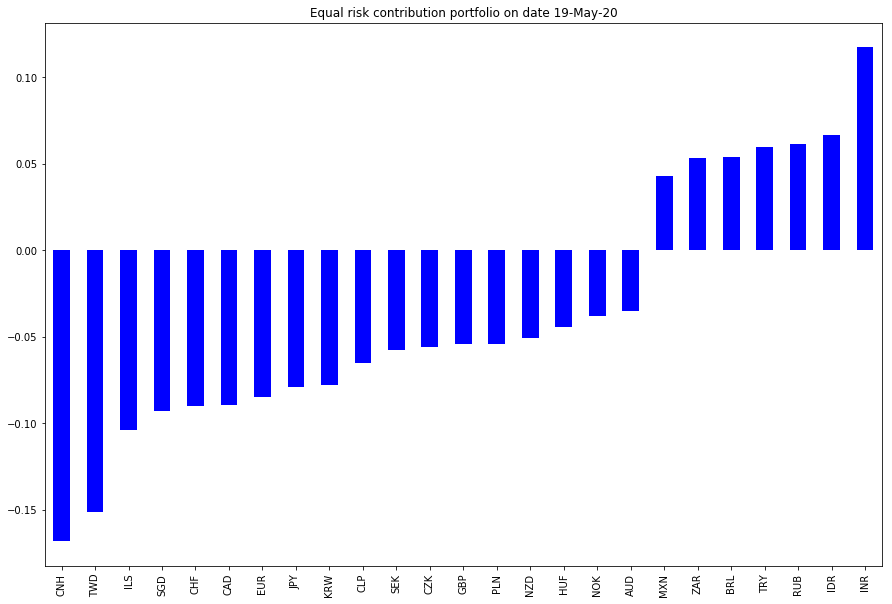

In [34]:
w0 = positions/np.abs(positions).sum()
res = opt.minimize(dist_to_target, w0, method='SLSQP',
                   bounds=optimization_bounds.values, constraints=cons)
weights = pd.Series(index=positions.index,data=res.x).sort_values()
weights.plot(kind='bar',figsize=(15,10),color='b',
                title='Equal risk contribution portfolio on date %s' % ref_date.strftime('%d-%b-%y'))
plt.show()

### Equal risk contribution problem expressed as a logarithmic barrier problem

It turns out that solving an artiﬁcal optimization problem that incorporates a logarithmic barrier term is equivalent to ﬁnding a the ERC portfolio. Let's take a look at the artiﬁcal optimization problem:

$$
\underset{w}{min} (w'\Sigma w - c\sum_{i=1}^{N}ln(w_{i}))
$$

where $c$ is just some arbitrary constant. The FOC of this problem are:

$$
\Sigma w - cw^{-1} = 0_{N\times1}
$$

where $w^{-1}\equiv(w_{1}^{-1},\dots,w_{N}^{-1})$. The FOC then imply that the $i$-th element of $\Sigma w$ is equal to $c/w_{i}$ which then implies that for every asset $i$ and asset $j$ in the portfolio you have $w_{i}(\Sigma w)_{i} = w_{j}(\Sigma w)_{j}$ and therefore:

$$
w_{i}\frac{\partial \sigma(w)}{\partial w_{i}} = w_{j}\frac{\partial \sigma(w)}{\partial w_{j}} = c
$$

which, in turn, as we saw above, implies that:

$$
RC(w) \equiv \frac{w}{\sigma(w)}\frac{\partial \sigma(w)}{\partial w} = w\frac{\Sigma w}{\sigma(w)^2} = N^{-1} \iota
$$

where $\iota$ is an $N\times1$ vector of ones.


## Maximum factor exposure portfolio

Maximum factor exposure is a portfolio construction method that takes correlations but unlike equal risk contribution and minimum variance portfolios, it uses the strength of the signal or expected returns, as the key goal of the weighting scheme. In fact, it attempts to maximize the factor exposure. When the signal or factor has a an interpretation of expected returns, we can think of maximum factor exposure portfolios as portfolios that are attempting to maximize portfolio returns.

### Factor exposure

For any vector of weights $w = (w_{1},\dots,w_{N})'$ we have the portfolio factor exposure function as the function:

$$
f(w) \equiv \sum_{i=1}^{N}w_{i}s_{i}
$$

where $s_{i}$ is the signal, characteristic or factor of asset $i$.

In [35]:
factor_exposure = lambda x : x.dot(signal_on_date)
print('This is the carry of the rank weighted portfolio: %s' % factor_exposure(rank_weights))
print('We want to maximize that!')

This is the carry of the rank weighted portfolio: 0.07652087976249276
We want to maximize that!


So, we find the set of weights that maximize $f(w)$ subject to a set of constraints:

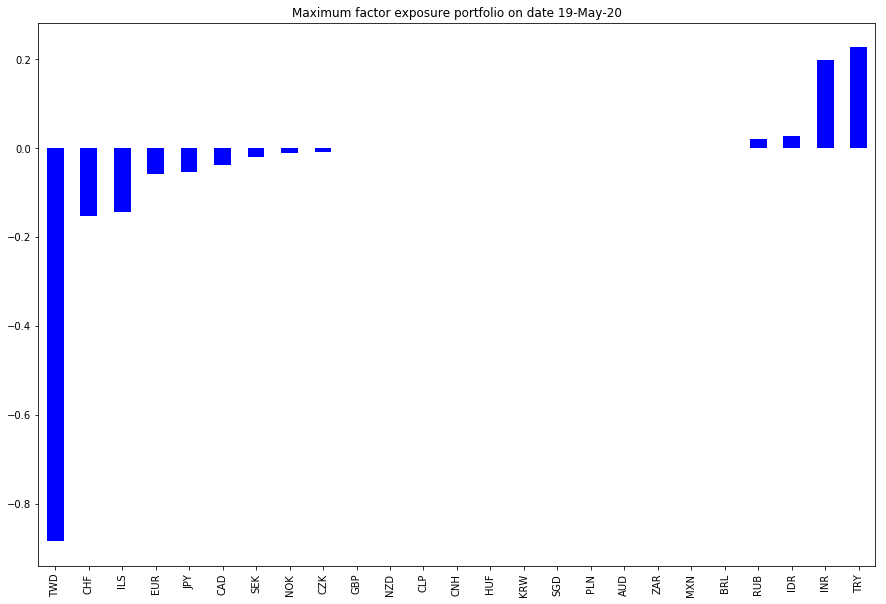

In [67]:
positions = np.sign(signal_on_date - signal_on_date.mean())
w0 = positions/np.abs(positions).sum()

factor_exposure = lambda x : -x.dot(signal_on_date)

res = opt.minimize(factor_exposure, w0, method='SLSQP',
                   bounds=optimization_bounds.values, constraints=cons)

weights = pd.Series(index=positions.index,data=res.x).sort_values()
weights.plot(kind='bar',figsize=(15,10),color='b',
                title='Maximum factor exposure portfolio on date %s' % ref_date.strftime('%d-%b-%y'))
plt.show()

### Controlling for concentration

Maybe we want to impose tighter bounds on the positions. As an example, let's look at a case where we impose that the positions in any particular asset will not be higher than $4/N$:

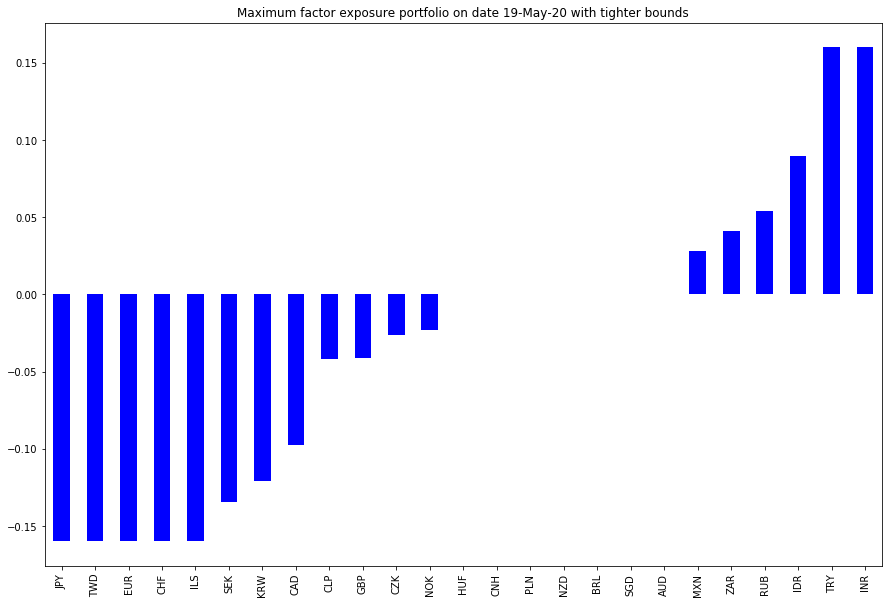

In [68]:
tighter_bounds = 4*optimization_bounds/optimization_bounds.shape[0]

res = opt.minimize(factor_exposure, w0, method='SLSQP',
                   bounds=tighter_bounds.values, constraints=cons)
weights = pd.Series(index=positions.index,data=res.x).sort_values()
weights.plot(kind='bar',figsize=(15,10),color='b',
                title='Maximum factor exposure portfolio on date %s with tighter bounds'\
             % ref_date.strftime('%d-%b-%y'))
plt.show()

## Beta to S&P 500

Often times, portfolios have residual exposures that we want to eliminate. For example, a carry portfolio in FX may be highly correlated with risk on/off market environments. Maybe we want to build a carry portfolio in FX that attempts to mitigate these types of residual exposures. Let's see an example where we try to mitigate the beta to the S&P 500 index.

### Simple monthly rebalacing backtest

Backtesting is a difficult and dangerous art. Here, let's use a simple monthly returns type of backtest just to make a few points.

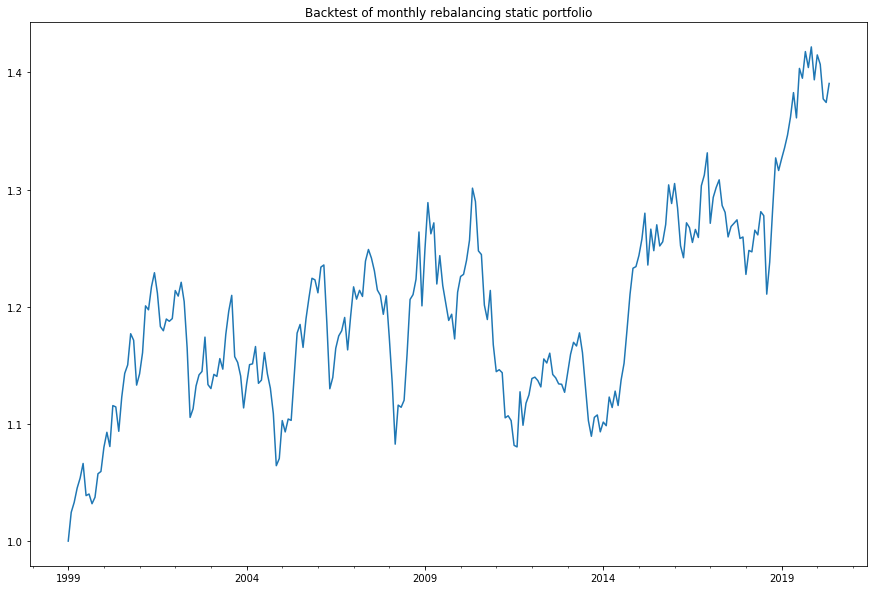

In [38]:
monthly_returns = tracker_df.resample('M').last().pct_change(1)
port_monthly_returns = (monthly_returns.fillna(0)@weights)
port_ts = (1+port_monthly_returns).cumprod()
port_ts.plot(title='Backtest of monthly rebalancing static portfolio',figsize=(15,10))
plt.show()

### Rolling correlation with the S&P 500

Let's look how our FX portfolio correlates with the S&P 500:

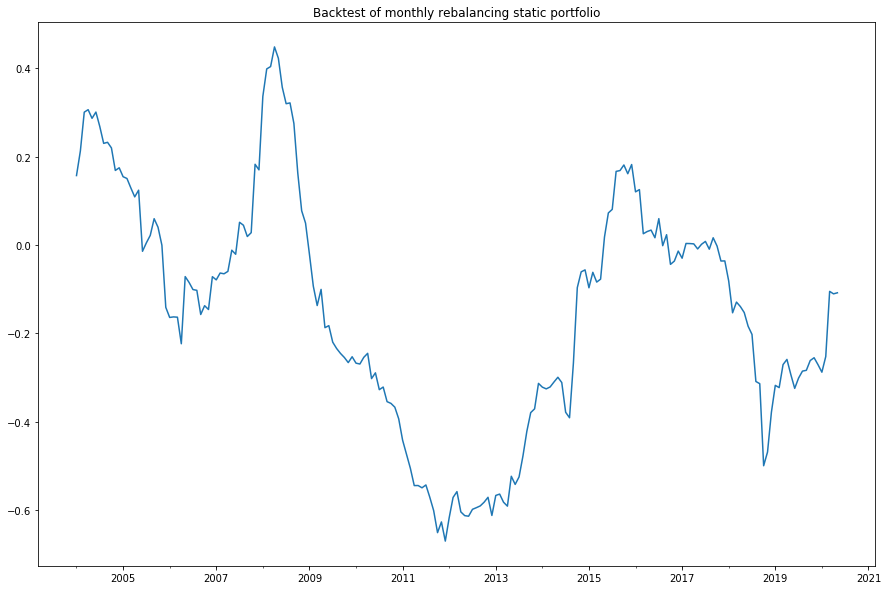

In [39]:
spx_monthly_returns = spx.resample('M').last().pct_change(1).iloc[:,0]
rolling_3Y_corr = port_monthly_returns.rolling(36).corr(spx_monthly_returns).dropna()
rolling_3Y_corr.plot(title='Backtest of monthly rebalancing static portfolio',figsize=(15,10))
plt.show()

### Beta estimation

Here we have the same three cases:

* Uncoditional beta estimate using the full sample
* Conditional beta estimate using EWMA
* Conditional beta estimate using rolling windows

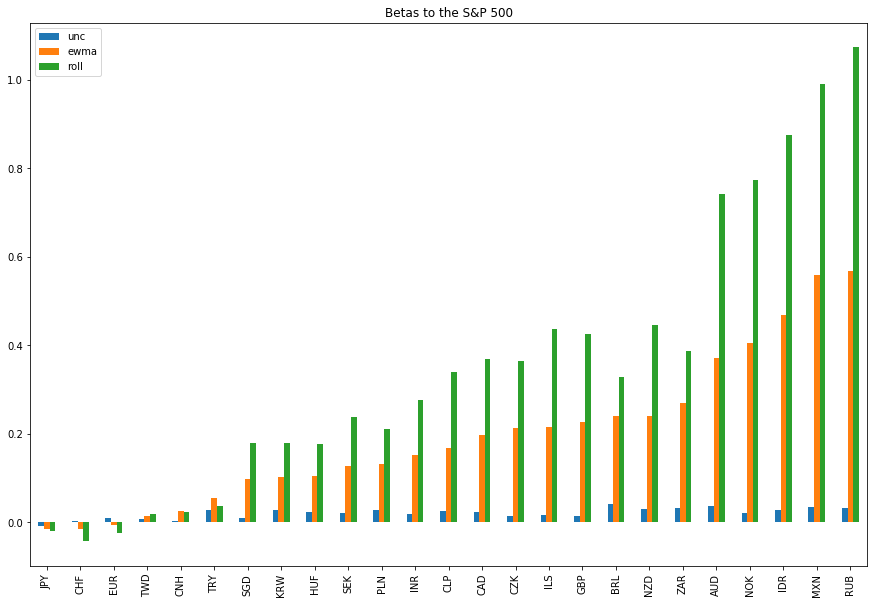

In [76]:
h = 21
tracker_df_and_spx = pd.concat([tracker_df,spx],axis=1,join='outer',sort=True).fillna(method='ffill')
all_returns = np.log(tracker_df_and_spx).diff(h)
unc_cov_all = (all_returns.cov() * (252 / h))
ewma_cov_all = all_returns.ewm(halflife=63).cov().loc[ref_date] * (252 / h)
roll_cov_all = all_returns.rolling(63).cov().loc[ref_date] * (252 / h)
unc_beta = unc_cov_all.iloc[:-1,-1]/roll_cov_all.iloc[-1,-1]
ewma_beta = ewma_cov_all.iloc[:-1,-1]/ewma_cov_all.iloc[-1,-1]
roll_beta = roll_cov_all.iloc[:-1,-1]/ewma_cov_all.iloc[-1,-1]
spx_betas = pd.concat([unc_beta.to_frame('unc'),ewma_beta.to_frame('ewma'),roll_beta.to_frame('roll')],
                      axis=1)
spx_betas.sort_values(by='ewma').plot(kind='bar',title='Betas to the S&P 500',figsize=(15,10))
plt.show()

### Portfolio beta constraint

For any vector of weights $w = (w_{1},\dots,w_{N})'$ we have the portfolio factor exposure function as the function:

$$
\beta(w) \equiv \sum_{i=1}^{N}w_{i}\beta_{i}
$$

where $\beta_{i}$ is the beta of asset $i$ relative to the S&P 500. Let's use the conditional beta estimate using EWMA to illustrate.

In [77]:
spx_beta = spx_betas.loc[right_order,'roll']
beta_to_spx = lambda x : x.dot(spx_beta)
print('This is the beta of the rank weighted portfolio: %s' % beta_to_spx(rank_weights))
print('We want to make that zero!')
cons2 = ({'type': 'ineq', 'fun': lambda x:  vol_target - port_vol(x)},
       {'type': 'eq', 'fun': lambda x:  0 - beta_to_spx(x)})

This is the beta of the rank weighted portfolio: 0.3550651319057856
We want to make that zero!


### Compare

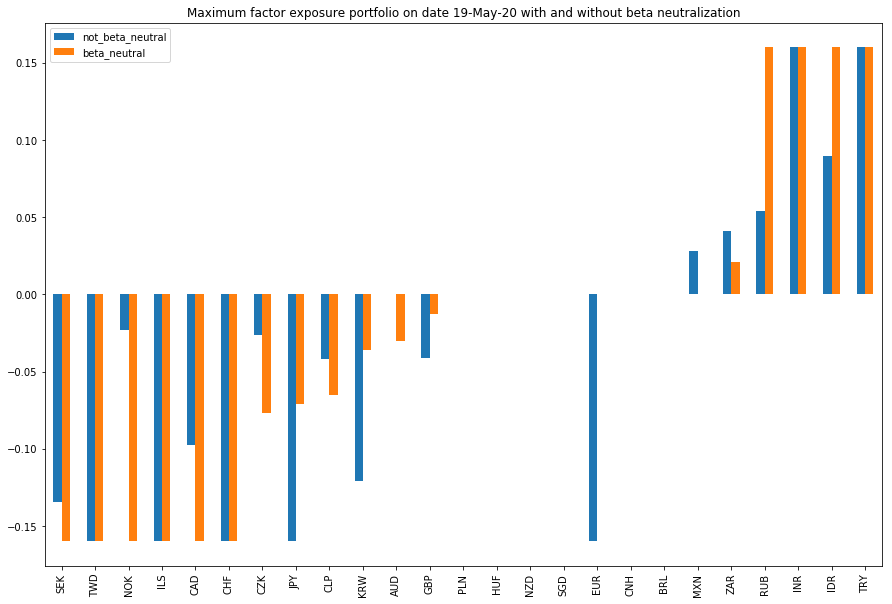

In [78]:
res = opt.minimize(factor_exposure, w0, method='SLSQP',
                   bounds=tighter_bounds.values, constraints=cons2)

weights2 = pd.Series(index=right_order,data=res.x).sort_values()
weights_df = pd.concat([weights.to_frame('not_beta_neutral'),weights2.to_frame('beta_neutral')],
                       axis=1,sort=True)
weights_df.sort_values(by='beta_neutral').plot(kind='bar',figsize=(15,10),
        title='Maximum factor exposure portfolio on date %s with and without beta neutralization'\
             % ref_date.strftime('%d-%b-%y'))
plt.show()

## Minimum distance portfolio

Minimum distance portfolios attempts to make the portfolio as close to some other portfolio as possible subject to a few constraints. Here let's use the rank based portfolio as our reference portfolio. So, we want to basically have the same exposures as the rank based portfolio but with a few extra constraints in terms of portfolio volatility, concentration and beta to the S&P 500.

We will find the vector $w$ that minimizes:

$$ \lVert w - w^{target} \rVert $$

subject to the same constraints as before:

In [43]:
dist_to_rank = lambda x: np.linalg.norm(x - rank_weights)
print('The distance between the this portfolio and the rank weights is: %s' \
                          % dist_to_rank(weights))
print('The idea is to make this as small as possible!')

The distance between the this portfolio and the rank weights is: 0.2627543010184696
The idea is to make this as small as possible!


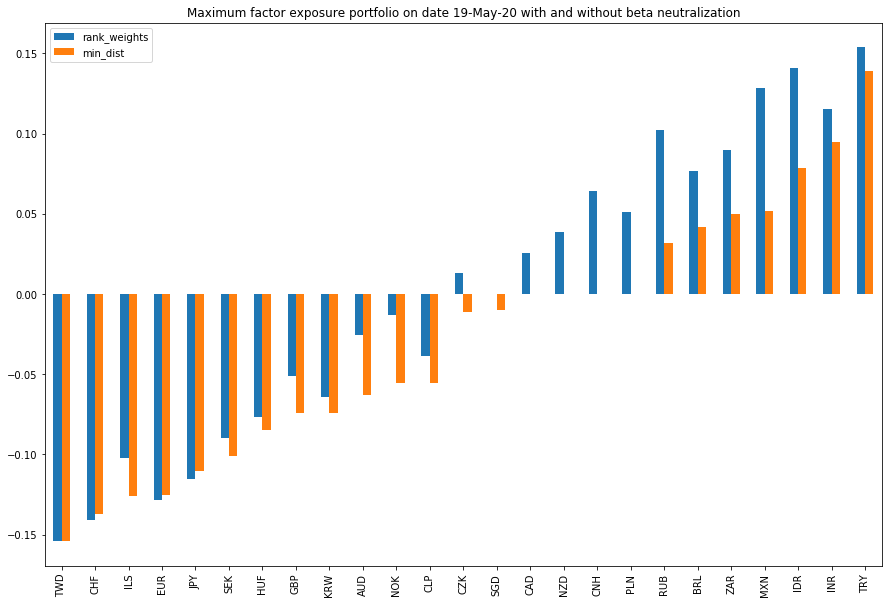

In [44]:
res = opt.minimize(dist_to_rank, w0, method='SLSQP',
                   bounds=tighter_bounds.values, constraints=cons2)

weights2 = pd.Series(index=right_order,data=res.x).sort_values()
weights_df = pd.concat([rank_weights.to_frame('rank_weights'),weights2.to_frame('min_dist')],
                       axis=1,sort=True)
weights_df.sort_values(by='min_dist').plot(kind='bar',figsize=(15,10),
        title='Maximum factor exposure portfolio on date %s with and without beta neutralization'\
             % ref_date.strftime('%d-%b-%y'))
plt.show()

## Transaction costs

It is also common to restrict or penalize for transaction costs in the portfolio construction method. We will show two simples cases. Let's say we want to maximize factor exposure but we want to increase or decrease weights relative to our current positions taking transaction costs into account. For example, let's say that it costs 2 bps to trade G10 currencies and 10 bps to trade all other currencies:

In [45]:
G10 = ['JPY', 'AUD', 'NOK', 'SEK', 'GBP', 'NZD','EUR', 'CAD', 'CHF']
cost_dict = {c : 2/10000 if c in G10 else 10/10000 for c in signal_on_date.index}

For any vector of weights $w = (w_{1},\dots,w_{N})'$ we have the portfolio factor exposure function penalized by transaction costs as the function:

$$
f(w) \equiv \sum_{i=1}^{N}w_{i}s_{i} - \lambda \sum_{i=1}^{N}TC_{i}|w_{i} - w_{i}^{current}|
$$

where $s_{i}$ is the signal, characteristic or factor of asset $i$ and $TC_{i}$ is the transaction costs from moving from portfolio $w^{current}$ to the new portfolio $w$. The penalization parameter $\lambda$ can be thought of as a [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) parameters. Ideally, this parameter would be cross-validated but for now, let's just assume a fixed value for it, $\lambda=1$.

Just as an illustration let's assume that the current portfolio is the rank based portfolio:

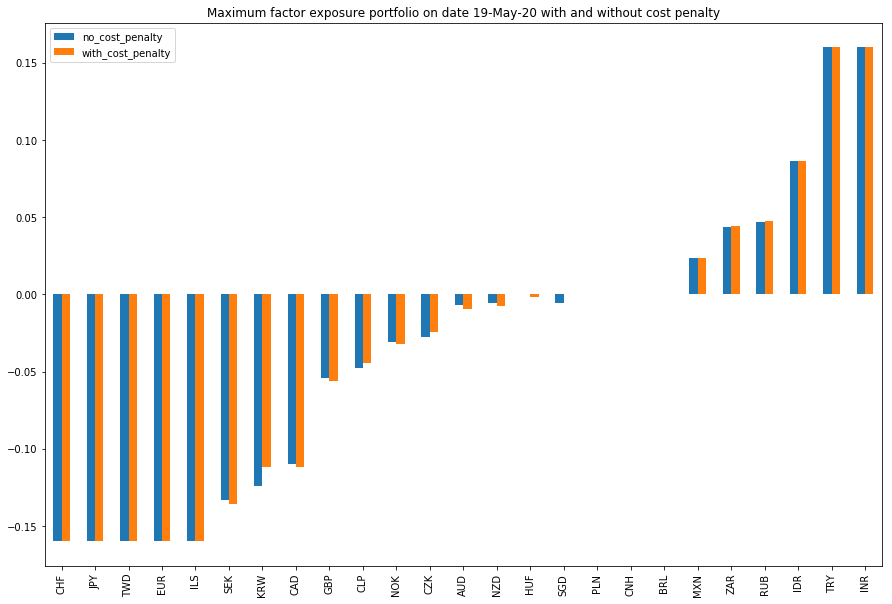

In [46]:
factor_exposure = lambda x : -np.dot(x,signal_on_date.values)

# costs
cost_penalization = 1
TC = np.array([cost_dict[x] for x in signal_on_date.index])

# current portfolio
w0 = signal_on_date.rank()-signal_on_date.rank().mean()
w0 = 2*w0/(np.abs(w0).sum())

# new objective function
rebalancing_costs = lambda x : np.dot(np.abs(x-w0.values),TC)
obj_function = lambda x : factor_exposure(x) + cost_penalization * rebalancing_costs(x)

# vol constraint
port_vol = lambda x: np.sqrt(x.dot(cov.loc[signal_on_date.index,signal_on_date.index]).dot(x))
cons = ({'type': 'ineq', 'fun': lambda x:  vol_target - port_vol(x)})

# optimization with costs
res = opt.minimize(obj_function, w0, method='SLSQP',
                   bounds=tighter_bounds.loc[w0.index].values, constraints=cons2)
weights1 = pd.Series(index=signal_on_date.index,data=res.x).sort_values()

# optimization without costs
res = opt.minimize(factor_exposure, w0, method='SLSQP',
                   bounds=tighter_bounds.loc[w0.index].values, constraints=cons2)
weights2 = pd.Series(index=signal_on_date.index,data=res.x).sort_values()


# compare
weights_df = pd.concat([weights2.to_frame('no_cost_penalty'),weights1.to_frame('with_cost_penalty') ],
                       axis=1,sort=True)
weights_df.sort_values(by='with_cost_penalty').plot(kind='bar',figsize=(15,10),
        title='Maximum factor exposure portfolio on date %s with and without cost penalty'\
             % ref_date.strftime('%d-%b-%y'))
plt.show()

## Group restrictions

Let's suppose we would like to impose the restriction that we never end up with a net exposure to non-G10 currencies. That is, when we add up the weights of the non-G10 currencies we get zero.

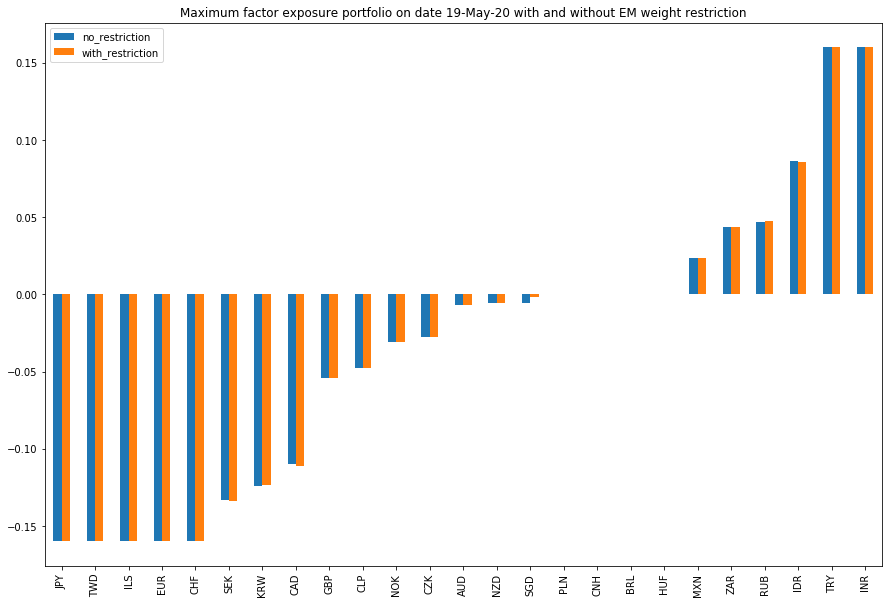

In [47]:
factor_exposure = lambda x : -np.dot(x,signal_on_date.values)

net_em_USD_notional = lambda x : np.abs(x[[c not in G10 for c in signal_on_date.index]].sum())
port_vol = lambda x: np.sqrt(x.dot(cov.loc[signal_on_date.index,signal_on_date.index]).dot(x))
spx_beta = spx_betas.loc[signal_on_date.index,'ewma']
beta_to_spx = lambda x : x.dot(spx_beta)

cons = ({'type': 'ineq', 'fun': lambda x:  vol_target - port_vol(x)},
        {'type': 'eq', 'fun': lambda x:  0 - beta_to_spx(x)},
        {'type': 'eq', 'fun': lambda x: 0. - net_em_USD_notional(x)},        
       )

res = opt.minimize(factor_exposure, w0, method='SLSQP',
                   bounds=tighter_bounds.loc[w0.index].values, constraints=cons)
weights1 = pd.Series(index=signal_on_date.index,data=res.x).sort_values()

cons = ({'type': 'ineq', 'fun': lambda x:  vol_target - port_vol(x)},
        {'type': 'eq', 'fun': lambda x:  0 - beta_to_spx(x)},                
       )

res = opt.minimize(factor_exposure, w0, method='SLSQP',
                   bounds=tighter_bounds.loc[w0.index].values, constraints=cons)
weights2 = pd.Series(index=signal_on_date.index,data=res.x).sort_values()

# compare
weights_df = pd.concat([weights2.to_frame('no_restriction'),weights1.to_frame('with_restriction') ],
                       axis=1,sort=True)
weights_df.sort_values(by='no_restriction').plot(kind='bar',figsize=(15,10),
        title='Maximum factor exposure portfolio on date %s with and without EM weight restriction'\
             % ref_date.strftime('%d-%b-%y'))
plt.show()